In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR


# Importing the Dataset

data = pd.read_csv('newfile_summer.csv')
gold=pd.DataFrame(data[['Country','Year','Gold']])

# Getting number of countries
country=pd.DataFrame(data['Country'])
country_cnt = len(country['Country'].value_counts())

#####################################################################################
# Creating a loop for each country in the dataframe

country_record = []
index = 0
country_name = gold.iloc[index][0]

while (len(country_record)<country_cnt):
    year = []
    gold_cnt = []
    while (country_name in country_record):
        index += 1
        country_name = gold.iloc[index][0]    
    country_record.append(country_name)
    
    print ("*********************************************************************************")
    print ('Country: ', country_name)
    
    #####################################################################################
    # Extracting gold and year data for the country, excluding year 1906 cos its not a multiple of 4 and its a fake olympics
    
    for i in range(len(gold)):
        if (gold.iloc[i][0] == country_name):
            if (gold.iloc[i][1]!=1906):
                year.append(gold.iloc[i][1])
                gold_cnt.append(gold.iloc[i][2])
    
    #####################################################################################
    # Calculating the missing values for years
    
    n = len(year)
    missing_years = []
    for i in range(n-1):
        if ((year[i+1])-(year[i])>4):
            curr = year[i]+4
            fin = year[i+1]
            while (curr<fin):
                missing_years.append(curr)
                curr += 4
    
    #####################################################################################
    # Converting python array format into numpy array format

    x = np.array(year)
    x_missing = np.array(missing_years)
    y = np.array(gold_cnt)
    
    ###############################################################################
    # Fit IsotonicRegression and LinearRegression models

    ir = IsotonicRegression()

    y_ = ir.fit_transform(x, y)

    lr = LinearRegression()
    lr.fit(x[:, np.newaxis], y)  # x needs to be 2d for LinearRegression
    
    ###############################################################################
    # Plotting initial data
    
    segments = [[[i, y[i]], [i, y_[i]]] for i in range(n)]
    lc = LineCollection(segments, zorder=0)
    lc.set_array(np.ones(len(y)))
    lc.set_linewidths(np.full(n, 1))
    p=(255,255,0)
    fig = plt.figure()
    plt.plot(x, y, 'b.', markersize=12)
    plt.plot(x, y_, 'y.-', markersize=12)
    plt.plot(x, lr.predict(x[:, np.newaxis]), 'r-')
    plt.gca().add_collection(lc)
    plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='upper left')
    plt.title(country_name)
    
    print("Before: ")
    plt.show()
    
    ###############################################################################
    # Predicting gold medal count for missing years and filling in data
    
    y_missing = ir.predict(x_missing).tolist() #
    
    for i in range(len(missing_years)):
        insert = 0
        while (missing_years[i]-year[insert]>0):
            insert += 1
        year.insert(insert, missing_years[i])
        gold_cnt.insert(insert, round(y_missing[i]))
    
    x_complete = np.array(year)
    y_complete = np.array(gold_cnt)
    
    ###############################################################################
    # Fit new IsotonicRegression and LinearRegression models
    
    ir = IsotonicRegression()

    y_ = ir.fit_transform(x_complete, y_complete)

    lr = LinearRegression()
    lr.fit(x_complete[:, np.newaxis], y_complete)  # x needs to be 2d for LinearRegression
    
    ###############################################################################
    # Plotting smoothed out data
    
    segments = [[[i, y_complete[i]], [i, y_[i]]] for i in range(n)]
    lc = LineCollection(segments, zorder=0)
    lc.set_array(np.ones(len(y_complete)))
    lc.set_linewidths(np.full(n, 1))
    p=(255,255,0)
    fig = plt.figure()
    plt.plot(x_complete, y_complete, 'b.', markersize=12)
    plt.plot(x_complete, y_, 'y.-', markersize=12)
    plt.plot(x_complete, lr.predict(x_complete[:, np.newaxis]), 'r-')
    plt.gca().add_collection(lc)
    plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='upper left')
    plt.title(country_name)

    print("After: ")
    plt.show()
    
    ###############################################################################
    # Insert code here
    # Optional code to predict using persistence model
    # Persistence model copies the entire model ahead by 1 time interval
    # Basically checking the correlation of our x and y used (y_t against y_t+1)
    
    print("Persistence model prediction: ")
    print("Correlation of y_t with y_t+1: ")
    
    #Create lagged dataset
    time = pd.DataFrame(year[1:])
    values = pd.DataFrame(gold_cnt)
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t', 't+1']
    result = dataframe.corr()
    print(result)
    
    X = dataframe.values
    data = X[1:len(X)]
    data_X, data_y = data[:,0], data[:,1]
    
    # persistence model
    def model_persistence(x):
        return x

    # walk-forward validation
    predictions = list()
    for x in data_X:
        yhat = model_persistence(x)
        predictions.append(yhat)
        
    test_score = mean_squared_error(data_y, predictions)
    print('Test RMSE: %.3f' % sqrt(test_score))
    # plot predictions vs expected
    plt.plot(time, data_y)
    plt.plot(time, predictions, color='red')
    plt.legend(('Actual', 'Predicted'), loc='upper left')
    
    plt.show()
    
    ###############################################################################
    # Performing auto regression, use last 15 year data to compare with predictions
    
    print ("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    print("Auto-correlation model prediction of last 15 years versus actual values: ")
    print()
    
    # split into train and test sets
    
    time = pd.DataFrame(year[-15:])
    series = pd.Series(gold_cnt)
    X = series.values
    train, test = X[1:len(X)-15], X[len(X)-15:]    
    
    # train autoregression
    model = AR(train)
    model_fit = model.fit()
    window = model_fit.k_ar
    coef = model_fit.params
    
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)+1):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
            
        # Data manipulation to correct for decimal places and negative medal count
        if (yhat < 0):
            yhat = 0
        yhat = round(yhat)
        
        if (t<len(test)):
            predictions.append(yhat)
            obs = test[t]
            #Choose if u want to append actual value or predicted value into model
            history.append(obs)
            #history.append(yhat)
            print('predicted=%f, expected=%f' % (yhat, obs))
        else:
            next_oly = yhat
    
    # Calculating RMSE for model comparison
    error = mean_squared_error(test, predictions)
    print('Test RMSE: %.3f' % sqrt(error))
    
    # Plot results
    plt.plot(time, test)
    plt.plot(time, predictions, color='red')
    plt.legend(('Actual', 'Predicted'), loc='upper left')
    plt.show()

    
    # Next Olympics prediction & plot
    print(">>>>>>>>>>>>>>Forecast>>>>>>>>>>>>>>")
    print("Next Olympics gold total will be: ",next_oly)
    future = list(year)
    future.append(2020)
    future = pd.DataFrame(future[-16:])
    predictions.append(next_oly)
    plt.plot(time, test)
    plt.plot(future, predictions, color='red')
    plt.legend(('Actual', 'Predicted'), loc='upper left')
    plt.show()
    
    print('\n')
    
    #Loop for first 5 countries
    if (len(country_record)==5):
        break
    
    


*********************************************************************************
Country:  AFG


TypeError: unsupported operand type(s) for -: 'str' and 'str'

Test RMSE: 4.219


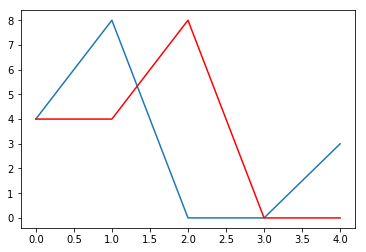

In [6]:
# #############################################################################
# Optional code to test for model persistance
# Basically checking the correlation of our x and y used

'''
    #Create lagged dataset
    values = pd.DataFrame(gold_cnt)
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t-1', 't+1']
    result = dataframe.corr()
    print(result)
    
    # persistence model
    def model_persistence(x):
        return x

    # walk-forward validation
    predictions = list()
    for x in test_X:
        yhat = model_persistence(x)
        predictions.append(yhat)
        
    test_score = mean_squared_error(test_y, predictions)
    print('Test RMSE: %.3f' % sqrt(test_score))
    # plot predictions vs expected
    plt.plot(test_y)
    plt.plot(predictions, color='red')
    plt.show()
'''

In [ ]:
# #############################################################################
# Plot result
'''
    segments = [[[i, y[i]], [i, y_[i]]] for i in range(n)]
    lc = LineCollection(segments, zorder=0)
    lc.set_array(np.ones(len(y)))
    lc.set_linewidths(np.full(n, 1))
    p=(255,255,0)
    fig = plt.figure()
    plt.plot(x, y, 'b.', markersize=12)
    plt.plot(x, y_, 'y.-', markersize=12)
    plt.plot(x, lr.predict(x[:, np.newaxis]), 'r-')
    plt.gca().add_collection(lc)
    plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')
    plt.title(country_name)

    plt.show()
'''   